In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [3]:
"""
Imputation Using Clustering vs. KNN – Detailed Comparison

We often consider clustering (e.g., KMeans) or K-Nearest Neighbors (KNN) as strategies for imputing missing values.
While both approaches rely on a notion of "similarity", they differ significantly in how they define and use it.

🔹 KMeans Clustering:
- Assigns each data point to a single cluster based on proximity to the cluster centroid.
- Imputation is done using the mean (or median) of the feature within that cluster.
- It's a coarse-grained approach: all members of a cluster get the same imputed logic.
- Pros:
    • Simple to compute and scale to large datasets.
    • Clusters offer interpretable groupings (e.g., regions, customer segments).
- Cons:
    • Assumes spherical clusters and clean separability, which is rarely true.
    • If a sample lies near a boundary, the cluster label may not reflect its true "neighbors".

🔹 K-Nearest Neighbors (KNN) Imputation:
- For each missing value, KNN finds the k most similar rows (using available features) and imputes based on their values.
- Each row gets a **custom** imputed value based on its nearest neighbors in feature space.
- Pros:
    • Fine-grained, local imputation — reflects individual row context.
    • Does not assume fixed group structure — works well with overlapping or complex data.
- Cons:
    • Can be slower for very large datasets (though approximate methods exist).
    • Sensitive to feature scaling and irrelevant features.

🔸 Why KNN Neighbors Don’t Always Belong to the Same Cluster:
- Clustering imposes **hard boundaries**; once a row is assigned to a cluster, it stays there, even if it's near other points in another cluster.
- KNN, on the other hand, computes actual distances — it can select neighbors from multiple clusters if they are closer.
- As a result, KNN is more flexible and better reflects the continuous nature of feature space.

✅ Summary:
- Prefer KNN for most small-to-medium datasets, especially when accuracy matters and the data has overlapping or complex patterns.
- Use KMeans if:
    • You're working with very large datasets where speed matters.
    • You care about grouping-based interpretation.
    • You want to quickly fill in coarse-grained missing values for downstream tasks.

In general, KNN is more precise for imputation, while clustering offers simplicity and interpretability.
"""

'\nImputation Using Clustering vs. KNN – Detailed Comparison\n\nWe often consider clustering (e.g., KMeans) or K-Nearest Neighbors (KNN) as strategies for imputing missing values.\nWhile both approaches rely on a notion of "similarity", they differ significantly in how they define and use it.\n\n🔹 KMeans Clustering:\n- Assigns each data point to a single cluster based on proximity to the cluster centroid.\n- Imputation is done using the mean (or median) of the feature within that cluster.\n- It\'s a coarse-grained approach: all members of a cluster get the same imputed logic.\n- Pros:\n    • Simple to compute and scale to large datasets.\n    • Clusters offer interpretable groupings (e.g., regions, customer segments).\n- Cons:\n    • Assumes spherical clusters and clean separability, which is rarely true.\n    • If a sample lies near a boundary, the cluster label may not reflect its true "neighbors".\n\n🔹 K-Nearest Neighbors (KNN) Imputation:\n- For each missing value, KNN finds the k 

/usr/local/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


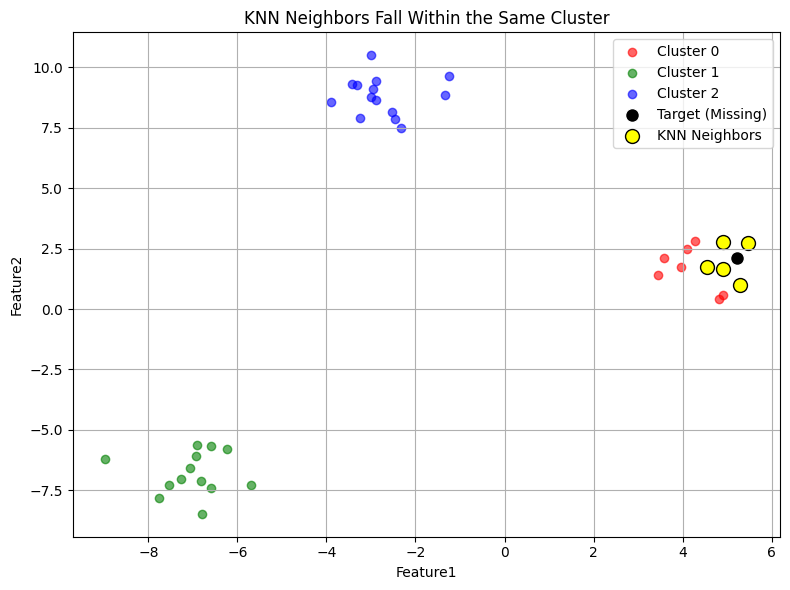

In [4]:
def generate_knn_cluster_plot(title, n_clusters, cluster_std, target_idx):
    # Generate synthetic 2D dataset with overlapping or well-separated clusters
    X, _ = make_blobs(n_samples=40, centers=n_clusters, cluster_std=cluster_std, random_state=42)
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df["Cluster"] = kmeans.fit_predict(df[["Feature1", "Feature2"]])

    # Fit KNN model
    knn_model = NearestNeighbors(n_neighbors=6)  # 5 neighbors + self
    knn_model.fit(df[["Feature1", "Feature2"]])
    distances, indices = knn_model.kneighbors([df.loc[target_idx, ["Feature1", "Feature2"]]])
    knn_indices = indices[0][1:]  # exclude self

    # Plot the clusters and neighbors
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue']
    for i in range(n_clusters):
        cluster_points = df[df['Cluster'] == i]
        plt.scatter(cluster_points["Feature1"], cluster_points["Feature2"], 
                    label=f'Cluster {i}', alpha=0.6, color=colors[i % len(colors)])

    # Highlight the target point
    plt.scatter(df.loc[target_idx, "Feature1"], df.loc[target_idx, "Feature2"], 
                color='black', s=100, label='Target (Missing)', edgecolor='white')
    
    # Highlight its KNN neighbors
    plt.scatter(df.loc[knn_indices, "Feature1"], df.loc[knn_indices, "Feature2"], 
                color='yellow', s=100, label='KNN Neighbors', edgecolor='black')

    plt.title(title)
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Case 1: KNN neighbors fall within the same cluster (low cluster_std)
generate_knn_cluster_plot(
    title="KNN Neighbors Fall Within the Same Cluster",
    n_clusters=3,
    cluster_std=0.8,
    target_idx=5
)

/var/folders/z0/f8x0px094r52y2v2fgmzyqmr0000gn/T/ipykernel_10126/1790958345.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


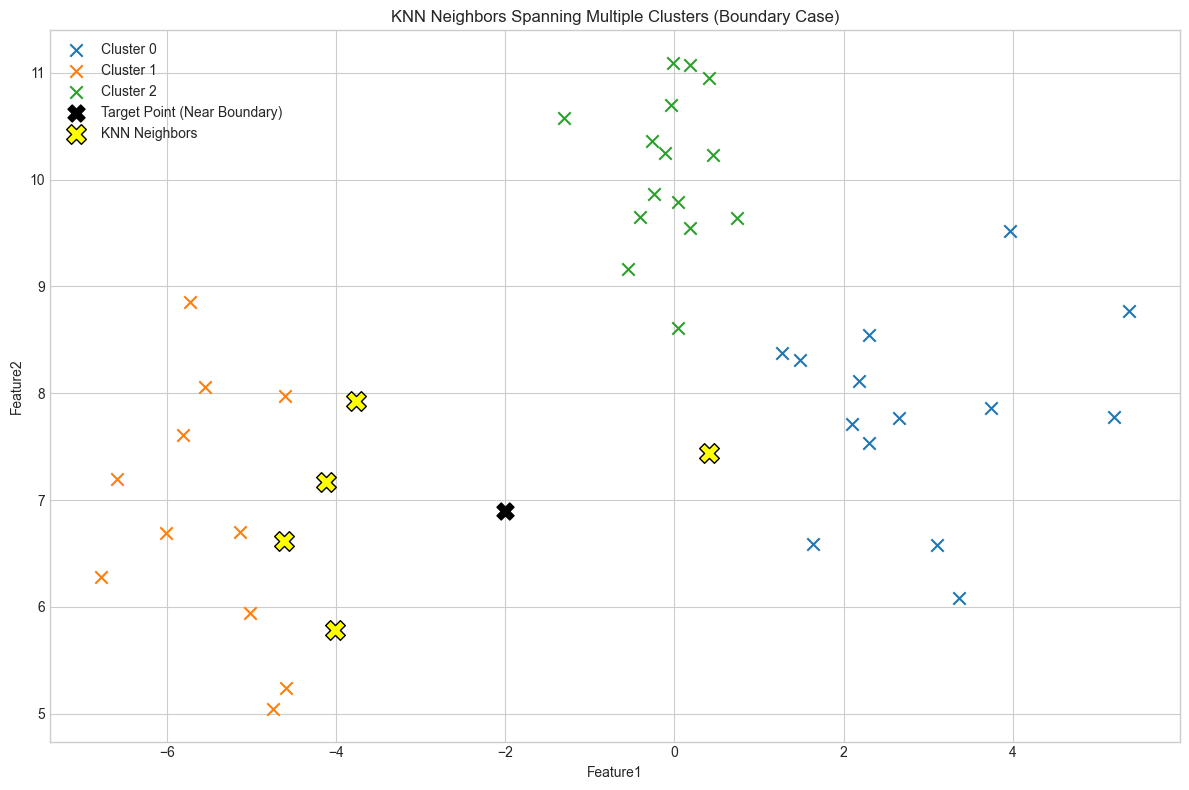

In [7]:
# 1. Generate three clusters of points
np.random.seed(42)
cluster0 = np.random.normal(loc=[3, 8], scale=[1.5, 1.0], size=(15, 2))    # Red cluster
cluster1 = np.random.normal(loc=[-5, 7], scale=[1.2, 1.0], size=(15, 2))   # Green cluster
cluster2 = np.random.normal(loc=[0, 10], scale=[0.5, 0.7], size=(15, 2))   # Blue cluster (tighter)

# 2. Stack them into one dataset
X = np.vstack([cluster0, cluster1, cluster2])

# 3. Define a target point near the boundary between cluster1 & cluster2
target = np.array([[-2.0, 6.9]])

# 4. Fit a NearestNeighbors model and find the 5 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(X)
dists, idxs = nbrs.kneighbors(target)
neighbors = X[idxs[0]]

# 5. Plot
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-whitegrid')

# plot each cluster
plt.scatter(cluster0[:, 0], cluster0[:, 1], c='C0', marker='x', s=80, label='Cluster 0')
plt.scatter(cluster1[:, 0], cluster1[:, 1], c='C1', marker='x', s=80, label='Cluster 1')
plt.scatter(cluster2[:, 0], cluster2[:, 1], c='C2', marker='x', s=80, label='Cluster 2')

# plot target point
plt.scatter(target[:, 0], target[:, 1],
            c='k', marker='X', s=150,
            label='Target Point (Near Boundary)')

# plot KNN neighbors
plt.scatter(neighbors[:, 0], neighbors[:, 1],
            c='yellow', marker='X', edgecolor='k', s=200,
            label='KNN Neighbors')

# labels & legend
plt.title('KNN Neighbors Spanning Multiple Clusters (Boundary Case)')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
# in the plot above, we can clearly see that when we take 5 nearest neighbours for the target feature sample for data imputation, the nieghbours are from 2 different clusters. So, clustering will end up ignoring the local nearest neighbours of the target feature.